In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils.utility import *

os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen
from GWGen.WFGenerator import *

# set initial parameters
M = 1e5
mu = 1e0
a = 0.
p0 = 14.0
e0 = 0.5
iota0 = 0.
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 0.
Phi_theta0 = 0.0
Phi_r0 = 0.0

# Generate trajectory using FEW package

/home/shaunf/.pyenv/versions/few_env/lib/python3.9/site-packages/few-1.4.6-py3.9-linux-x86_64.egg/few/trajectory/inspiral.py:233: UserWarning: Our model with spin breaks near a = 0. Adjusting to a = 1e-6.
  warnings.warn(


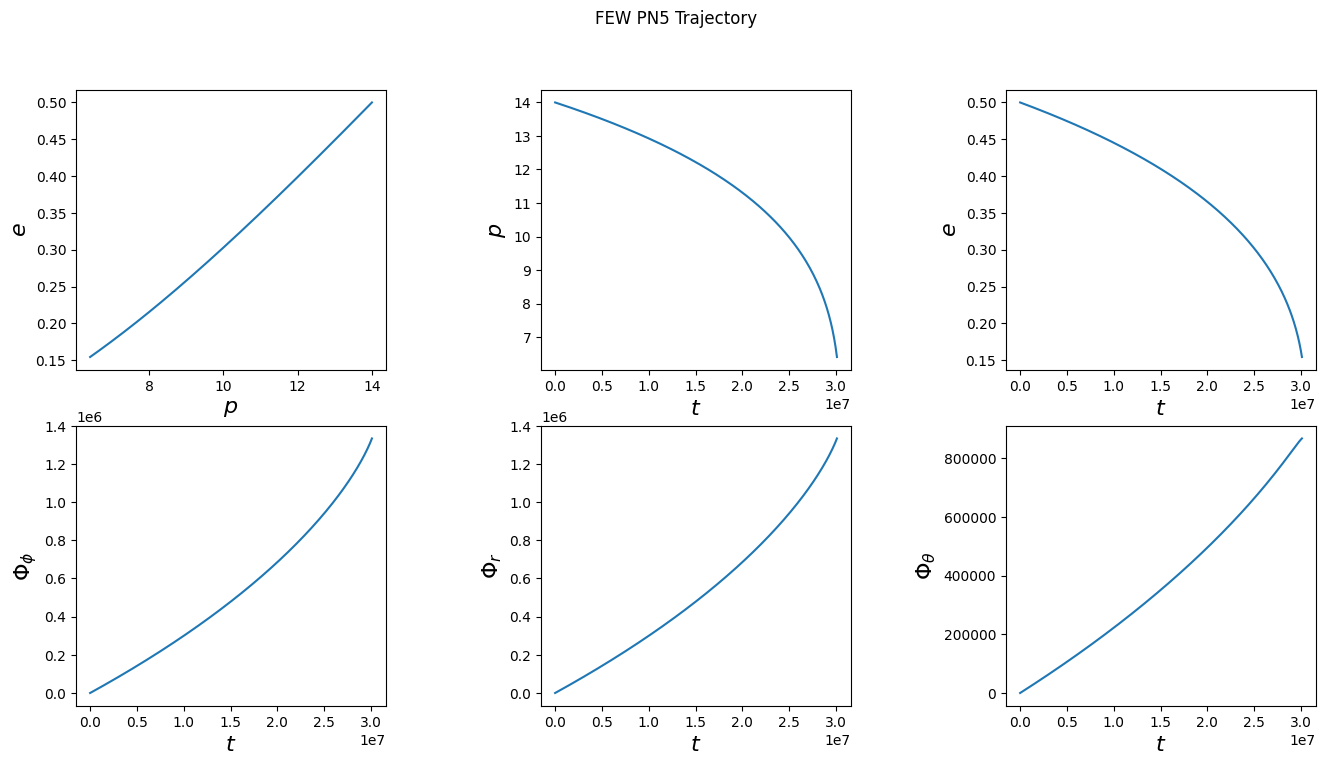

In [2]:
# initialize trajectory class
fewtraj = EMRIInspiral(func="pn5")
# set initial parameters
M = 1e5
mu = 1e0
a = 0.
p0 = 14.0
e0 = 0.5
iota0 = 0.
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 0.
Phi_theta0 = 0.0
Phi_r0 = 0.0

# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = fewtraj(M, mu, a, p0, e0, Y0,
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)

fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(16, 8)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$',  r'$t$', r'$t$', r'$t$']
ys = [e, p, e,  Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t]
for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
fig.suptitle("FEW PN5 Trajectory");

# Generate traj using pn5 example in FEW documentation

In [9]:
# we need to import an integrator and elliptic integrals
from mpmath import *
from scipy.integrate import DOP853

# base classes
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

# settings for elliptic integrals
mp.dps = 25
mp.pretty = True

# constants from our package
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class testPN:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y

        # guard against bad integration steps
        if e >= 1.0 or e < 1e-2 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0,0.,0.]


        # perform elliptic calculations
        EllipE = ellipe(4*e/(p-6.0+2*e))
        EllipK = ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -epsilon*(EdotPN)
        Ldot = -epsilon*(LdotPN)

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class testPnTrajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M
        integrator = DOP853(PN(epsilon,bhspin=a), 0.0, y0, T, max_step = T/100)

        t_out, p_out, e_out = [0.], [p0], [e0]
        Phi_phi_out, Phi_r_out = [0.], [0.]
        
        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            integrator.step()
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            if (p - get_separatrix(a,e,1.)) < 0.1:
                run = False
            if e<0 or e>1:
                run=False

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)

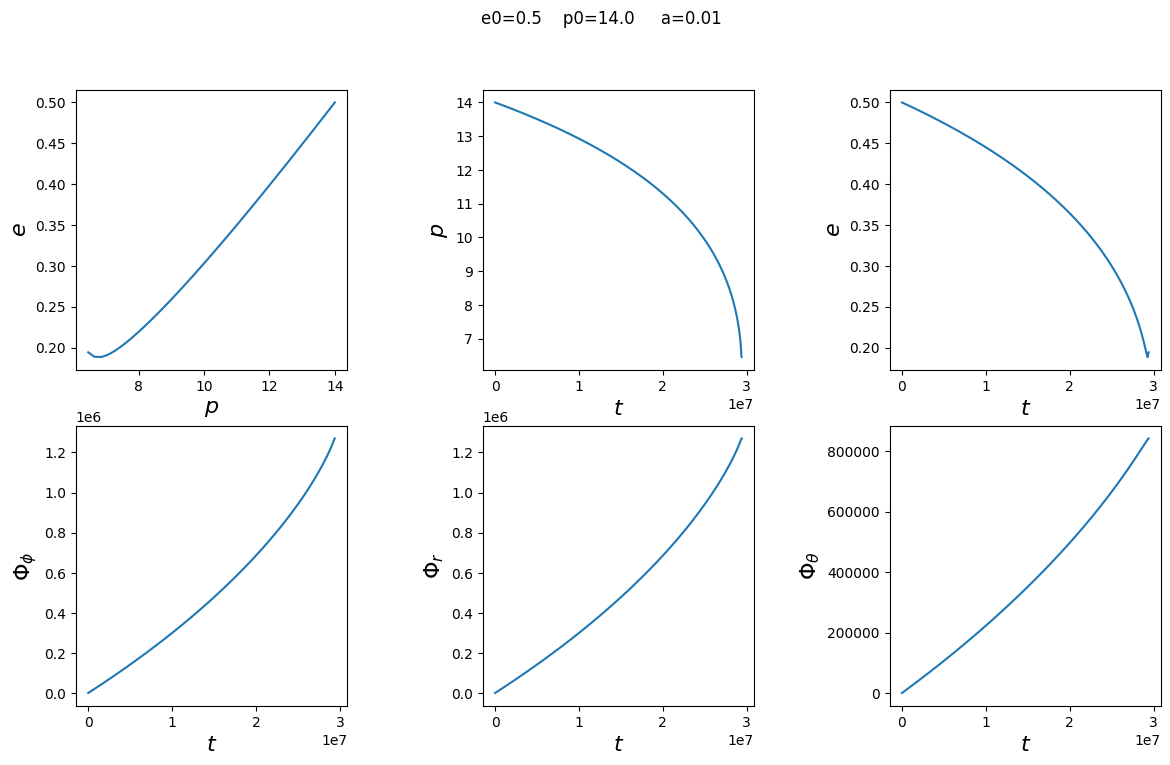

In [8]:
traj = testPnTrajectory()
a=1e-2
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0,T=2)
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e,  Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

fig.suptitle("e0={0}    p0={1}     a={2}".format(e0,p0,a));

# Generate trajectory using my code

In [2]:
traj = PnTraj(bhspin=1e-2)
t,p,e,x,phiphi,phitheta,phir = traj(M,mu,a,p0,e0,Y0,T=2)


fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(16, 8)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$',  r'$t$', r'$t$', r'$t$']
ys = [e, p, e,  phiphi, phir, phitheta]
xs = [p, t, t, t, t, t]
for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
fig.suptitle("My PN5 Trajectory");

14.0
0.5
nan
nan


/home/shaunf/Documents/Computer/Code/projects/Massive_Vector_Field_Dynamical_Friction/ProcaAroundKerr/GWGenerator/GWGen/Utils/Kerr.py:52: RuntimeWarning: invalid value encountered in double_scalars
  res = lambda e,p:Sqrt((a**2*(1 + 3*e**2 + p) + p*(-3 - e**2 + p - 2*Sqrt((a**6*(-1 + e**2)**2 + a**2*(-4*e**2 + (-2 + p)**2)*p**2 + 2*a**4*p*(-2 + p + e**2*(2 + p)))/p**3)))/(-4*a**2*(-1 + e**2)**2 + (3 + e**2 - p)**2*p)) + (p*(-((3 + e**2 - 3*p)*(3 + e**2 - p)*(a**2*(1 + 3*e**2 + p) + p*(-3 - e**2 + p - 2*Sqrt((a**6*(-1 + e**2)**2 + a**2*(-4*e**2 + (-2 + p)**2)*p**2 + 2*a**4*p*(-2 + p + e**2*(2 + p)))/p**3)))) + ((-4*a**2*(-1 + e**2)**2 + (3 + e**2 - p)**2*p)*(a**6*(-1 + e**2)**2 - 2*a**4*(1 + e**2)*p**2 + p**3*(-3 - e**2 + 2*p)*Sqrt((a**6*(-1 + e**2)**2 + a**2*(-4*e**2 + (-2 + p)**2)*p**2 + 2*a**4*p*(-2 + p + e**2*(2 + p)))/p**3) - a**2*p**2*(4 - 4*e**2 - 8*p + 3*p**2 - p*Sqrt((a**6*(-1 + e**2)**2 + a**2*(-4*e**2 + (-2 + p)**2)*p**2 + 2*a**4*p*(-2 + p + e**2*(2 + p)))/p**3))))/(p**3*Sqrt